# **Telco Customer Churn**

# **1. Business Problem Understanding**

Sebuah perusahaan yang bergerak di bidang telekomunikasi hendak meningkatkan pelayanannya untuk mempertahankan customer mereka. Perusahaan ingin mengetahui customer mana yang akan meninggalkan jasa mereka (churn) melalui data-data yang dimiliki.

Target :

0 : Tidak Churn

1 : Churn

**Problem Statement :**

Biaya yang di alokasikan untuk marketing bukanlah sedikit. Biaya marketing ini tidak hanya untuk mendapatkan customer baru, namun juga mempertahankan customer yang sudah ada. Agar alokasi biaya lebih baik maka perusahaan akan lebih baik ketika dapat mengalokasikan biaya marketingnya pada customer yang tepat.<br>

Jika biaya dialokasikan untuk mempertahankan customer agar tidak churn, namun ternyata customer tersebut churn, maka biaya tersebut akan sia-sia.<br>
Jika tidak mengalokasikan biaya marketing untuk customer yang akan churn, dan customer tersebut churn, maka biaya marketing diawal untuk mendapatkan customer juga akan sia-sia.

**Goals :**

Mampu memprediksi customer yang akan churn atau tidak, serta mampu mengetahui faktor apa saja yang mempengaruhi seorang customer churn atau tidak.

**Analytic Approach :**

Kita akan melakukan analisa untuk menemukan pola kecenderungan terhadap customer yang akan churn dan yang tidak churn.
Kemudian akan dibangun model klasifikasi yang akan membantu perusahaan memprediksi probabilitas seorang kandidat yang akan atau tidak churn.

**Metric Evaluation :**

Type 1 error : False Positive  
Konsekuensi: biaya marketing yang sia-sia.

Type 2 error : False Negative  
Konsekuensi: kehilangan customer.

Berdasarkan konsekuensinya, False Negative memiliki biaya yang lebih tinggi dibandingkan dengan False Positive. <br>
Karena biaya marketing yang dikeluarkan untuk mendapatkan customer baru cenderung lebih besar. <br>
Sehingga ketika kehilangan customer, biaya marketing untuk mendapatkan customer tersebut sama dengan sia-sia.

# **2. Library**

In [520]:
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Statistik
from scipy.stats import normaltest,kruskal,chi2_contingency

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix, recall_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures

# Feature Selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Engineering
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set max columns & rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

# **3. Data Understanding**

In [521]:
# A. Keterangan Atribut
# _____________________________________________________________________________________________________________________

keterangan_atribut = pd.DataFrame({   
    'Atribut'       : [ 'Dependents','Tenure','OnlineSecurity','OnlineBackup',
                        'InternetService','DeviceProtection','TechSupport','Contract','PaperlessBilling',
                        'MonthlyCharges','Churn'],
    'Keterangan'    : [ 'Apakah customer memiliki tanggungan atau tidak (Yes or no)',
                        'Lamanya customer berlangganan (xx bulan)',
                        'Apakah customer memiliki online security atau tidak (Yes, no, no internet service)',
                        'Apakah customer memiliki online backup atau tidak (Yes, no, no internet service)',
                        'Internet provide yang digunakan oleh customer (DSL, Fiber optic, No)',
                        'Apakah customer memiliki device protection atau tidak (Yes, No, No internet service)',
                        'Apakah customer memilki tech support atau tidak (Yes, No, No internet service)',
                        'Jangka waktu kontrak customer (Month-to-month, One year, Two year)',
                        'Apakah customer memiliki paperless billing (Yes or no)',
                        'Jumlah yang dibebankan kepada customer setiap bulan ($)',
                        'Apakah customer meninggalkan perusahaan atau tidak (Yes or no)']
})
keterangan_atribut

,Atribut,Keterangan
0,Dependents,Apakah customer memiliki tanggungan atau tidak (Yes or no)
1,Tenure,Lamanya customer berlangganan (xx bulan)
2,OnlineSecurity,"Apakah customer memiliki online security atau tidak (Yes, no, no internet service)"
3,OnlineBackup,"Apakah customer memiliki online backup atau tidak (Yes, no, no internet service)"
4,InternetService,"Internet provide yang digunakan oleh customer (DSL, Fiber optic, No)"
5,DeviceProtection,"Apakah customer memiliki device protection atau tidak (Yes, No, No internet service)"
6,TechSupport,"Apakah customer memilki tech support atau tidak (Yes, No, No internet service)"
7,Contract,"Jangka waktu kontrak customer (Month-to-month, One year, Two year)"
8,PaperlessBilling,Apakah customer memiliki paperless billing (Yes or no)
9,MonthlyCharges,Jumlah yang dibebankan kepada customer setiap bulan ($)


- Customers who left within the last month — Churn.
- Services that each customer has signed up for — online security, online backup, internet service, device protection, tech support
- Customer account information — tenure, contract, paperless billing, monthly charges
- Demographic info about customers — dependents

In [522]:
# B. Load Dataset
# _____________________________________________________________________________________________________________________

df = pd.read_csv('data_telco_customer_churn.csv')
df.head(2)

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No


# **4. Data Cleaning**

Untuk melakukan data cleaning, pertama-tama kita akan mencari tahu terlebih dahulu informasi mengenai dataset yang kita miliki.

In [523]:
# A. Dataset Shape
# _____________________________________________________________________________________________________________________

df.shape

(4930, 11)

Berdasarkan keterangan diatas, dataset kita memiliki **11 kolom dan 4930 baris**.

In [524]:
# B. Dataset Information
# _____________________________________________________________________________________________________________________

dataframe_info = []
for col in df.columns :
    dataframe_info.append([ col, df[col].dtype, df.count().loc[col],
                            df[col].isna().sum(), 
                            round((df[col].isna().sum()/len(df[col])) * 100,2),
                            df[col].nunique(), 
                            list(df[col].unique())]);

df_info = pd.DataFrame(columns=['Atribut', 'Tipe_Data', 'Jumlah_Data', 'Jumlah_Null', 'Null_%', 'Total_Unik', 'Nilai_Unik'],
                     data=dataframe_info)
df_info

,Atribut,Tipe_Data,Jumlah_Data,Jumlah_Null,Null_%,Total_Unik,Nilai_Unik
0,Dependents,object,4930,0,0.0,2,"[Yes, No]"
1,tenure,int64,4930,0,0.0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,object,4930,0,0.0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,4930,0,0.0,3,"[No, Yes, No internet service]"
4,InternetService,object,4930,0,0.0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,4930,0,0.0,3,"[Yes, No internet service, No]"
6,TechSupport,object,4930,0,0.0,3,"[Yes, No, No internet service]"
7,Contract,object,4930,0,0.0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,4930,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,4930,0,0.0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


Melalui keterangan pada df_info dan df_shape, jumlah data setiap kolom adalah 4930.<br>
Sehingga dapat disimpulkan **tidak terdapat missing values** didalam dataset.<br>
Selanjutnya kita akan mencari apakah didalam dataset terdapat nilai duplikat atau tidak.

In [525]:
# C. Duplicate Values
# _____________________________________________________________________________________________________________________

df.duplicated().sum()

77

Berdasarkan keterangan diatas, terdapat **77 nilai duplikat** didalam dataset.<br>
Sehingga, nilai-nilai duplikat tersebut akan dihapus.

In [526]:
# D. Drop Duplicate Values
# _____________________________________________________________________________________________________________________

df = df.drop_duplicates(keep='first')

Setelah data duplikat terhapus, selanjutnya kita akan mencari tahu kembali ukuran **dimensi dari dataset baru kita**.

In [527]:
# E. New Dataset Shape
# _____________________________________________________________________________________________________________________

df.shape

(4853, 11)

Melalui keterangan diatas, dataset yang baru memiliki **11 kolom 4853 baris**.

In [528]:
# F. Target (Churn Column) Value Counts
# _____________________________________________________________________________________________________________________

persentase_data_churn = pd.DataFrame(df['Churn'].value_counts()/len (df)).reset_index().rename(columns={'index':'Churn','Churn':'%'})
jumlah_data_churn = pd.DataFrame(df['Churn'].value_counts()).reset_index().rename(columns={'index':'Churn','Churn':'Jumlah'})
persentase_data_churn

,Churn,%
0,No,0.734597
1,Yes,0.265403


In [529]:
jumlah_data_churn

,Churn,Jumlah
0,No,3565
1,Yes,1288


Melalui dataframe diatas, dapat dilihat bahwa data target kita yaitu **'Churn'** tergolong kedalam **'Mild Imbalance'**.<br>
Selanjutnya kita akan melakukan eksplorasi untuk setiap tipe data.

## **4.A Data Numerikal**

In [530]:
# A. Numerical Data Description
# _____________________________________________________________________________________________________________________

df.describe()[['tenure','MonthlyCharges']]

,tenure,MonthlyCharges
count,4853.000000,4853.000000
mean,32.679992,65.321543
std,24.395554,29.783655
min,0.000000,18.800000
25%,9.000000,40.050000
50%,29.000000,70.600000
75%,56.000000,90.050000
max,72.000000,118.650000


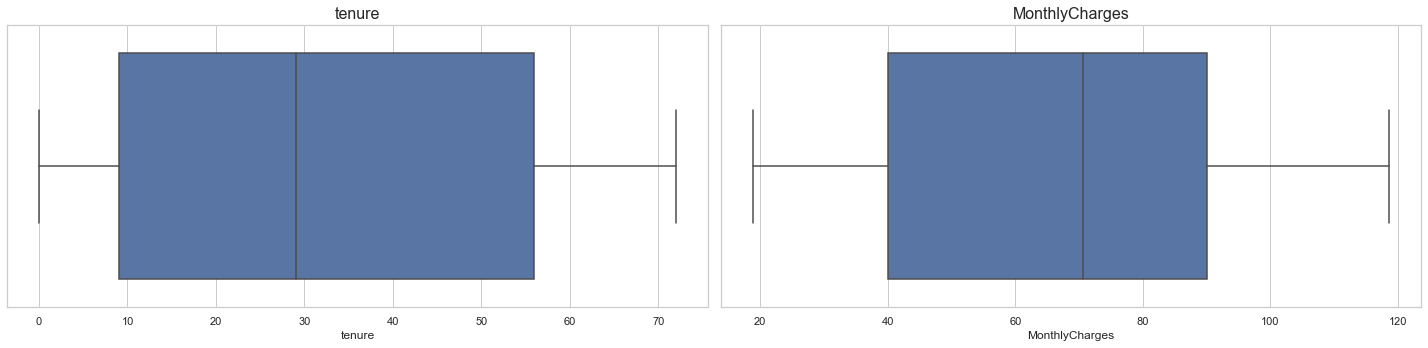

In [531]:
# B. Outlier
# _____________________________________________________________________________________________________________________

atribut_numerikal = [atribut for atribut in df.describe().columns]
plt.figure(figsize=(20, 5), facecolor='white')
sns.set(style='whitegrid')
nomor_plot = 1
     
for atribut in atribut_numerikal:
    ax = plt.subplot(1,2, nomor_plot)
    sns.boxplot(x=atribut, data=df);
    plt.title(atribut, fontsize=16)
    plt.tight_layout()
    nomor_plot = nomor_plot + 1

Berdasarkan boxplot diatas dapat dilihat bahwa data tenure dan MonthlyCharges tidak memiliki outlier.

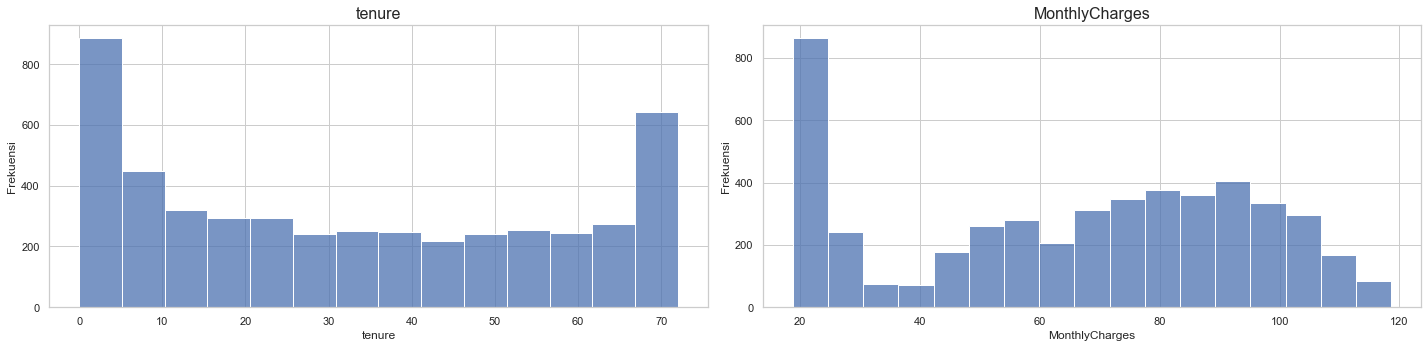

In [532]:
# C. Data Distribution with Plot
# _____________________________________________________________________________________________________________________

atribut_numerikal = [atribut for atribut in df.describe().columns]
plt.figure(figsize=(20, 5), facecolor='white')
sns.set(style='whitegrid')
nomor_plot = 1
     
for atribut in atribut_numerikal:
    ax = plt.subplot(1,2, nomor_plot)
    sns.histplot(x=atribut, data=df);
    plt.title(atribut, fontsize=16)
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    nomor_plot = nomor_plot + 1

Melalui grafik diatas, dapat disimpulkan bahwa data tenure dan monthlycharges distribusinya tidak normal (Right Skewed). <br>
Namun hal ini akan kita pastikan lagi dengan melakukan uji normalitas.

Hypothesis
- Ho: Data terdistribusi normal
- Ha: Data tidak terdistribusi normal

In [533]:
# D. Data Distribution with Test
# _____________________________________________________________________________________________________________________

# uji yang dipilih adalah normaltest, karena dapat menangani jumlah data lebih dari 1000

atribut_numerikal = [fea for fea in df.describe().columns]
list_atribut = []
list_distribusi = []

for i in atribut_numerikal :
    stat, pvalue = normaltest(df[i].dropna())
    if pvalue > 0.05:
        list_distribusi.append('Normal')
    else:
        list_distribusi.append('Tidak Normal')
    list_atribut.append(i)

df_distribusi = pd.DataFrame(list_distribusi,list_atribut)
df_distribusi.rename(columns={0:'Distribusi'}, inplace=True)
df_distribusi.T

,tenure,MonthlyCharges
Distribusi,Tidak Normal,Tidak Normal


Berdasarkan uji normalitas diatas, dengan nilai alpha 0.05, data tenure dan monthlycharges terdistribusi tidak normal. 

## **4.B Data Kategorikal**

In [534]:
# A. Categorical Data Description
# _____________________________________________________________________________________________________________________

df.describe(include=['O'])

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4853,4853,4853,4853,4853,4853,4853,4853,4853
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3380,2420,2148,2154,2162,2442,2665,2925,3565


In [535]:
# B. Churn Proportion per Attribute (Table)
# _____________________________________________________________________________________________________________________

atribut_kategorikal = ([atribut for atribut in df.describe(include=['O']).columns])
atribut_kategorikal.remove('Churn')

for i in atribut_kategorikal:
    churn = df.groupby(i)['Churn'].value_counts(normalize=True).unstack()
    display(churn.sort_values(by='Yes', ascending=False))

Churn,No,Yes
Dependents,,
No,0.685207,0.314793
Yes,0.847929,0.152071


Churn,No,Yes
OnlineSecurity,,
No,0.586364,0.413636
Yes,0.851748,0.148252
No internet service,0.925224,0.074776


Churn,No,Yes
OnlineBackup,,
No,0.597765,0.402235
Yes,0.794947,0.205053
No internet service,0.925224,0.074776


Churn,No,Yes
InternetService,,
Fiber optic,0.581244,0.418756
DSL,0.816627,0.183373
No,0.925224,0.074776


Churn,No,Yes
DeviceProtection,,
No,0.616096,0.383904
Yes,0.773104,0.226896
No internet service,0.925224,0.074776


Churn,No,Yes
TechSupport,,
No,0.590909,0.409091
Yes,0.848011,0.151989
No internet service,0.925224,0.074776


Churn,No,Yes
Contract,,
Month-to-month,0.568480,0.431520
One year,0.898565,0.101435
Two year,0.972003,0.027997


Churn,No,Yes
PaperlessBilling,,
Yes,0.668034,0.331966
No,0.835581,0.164419


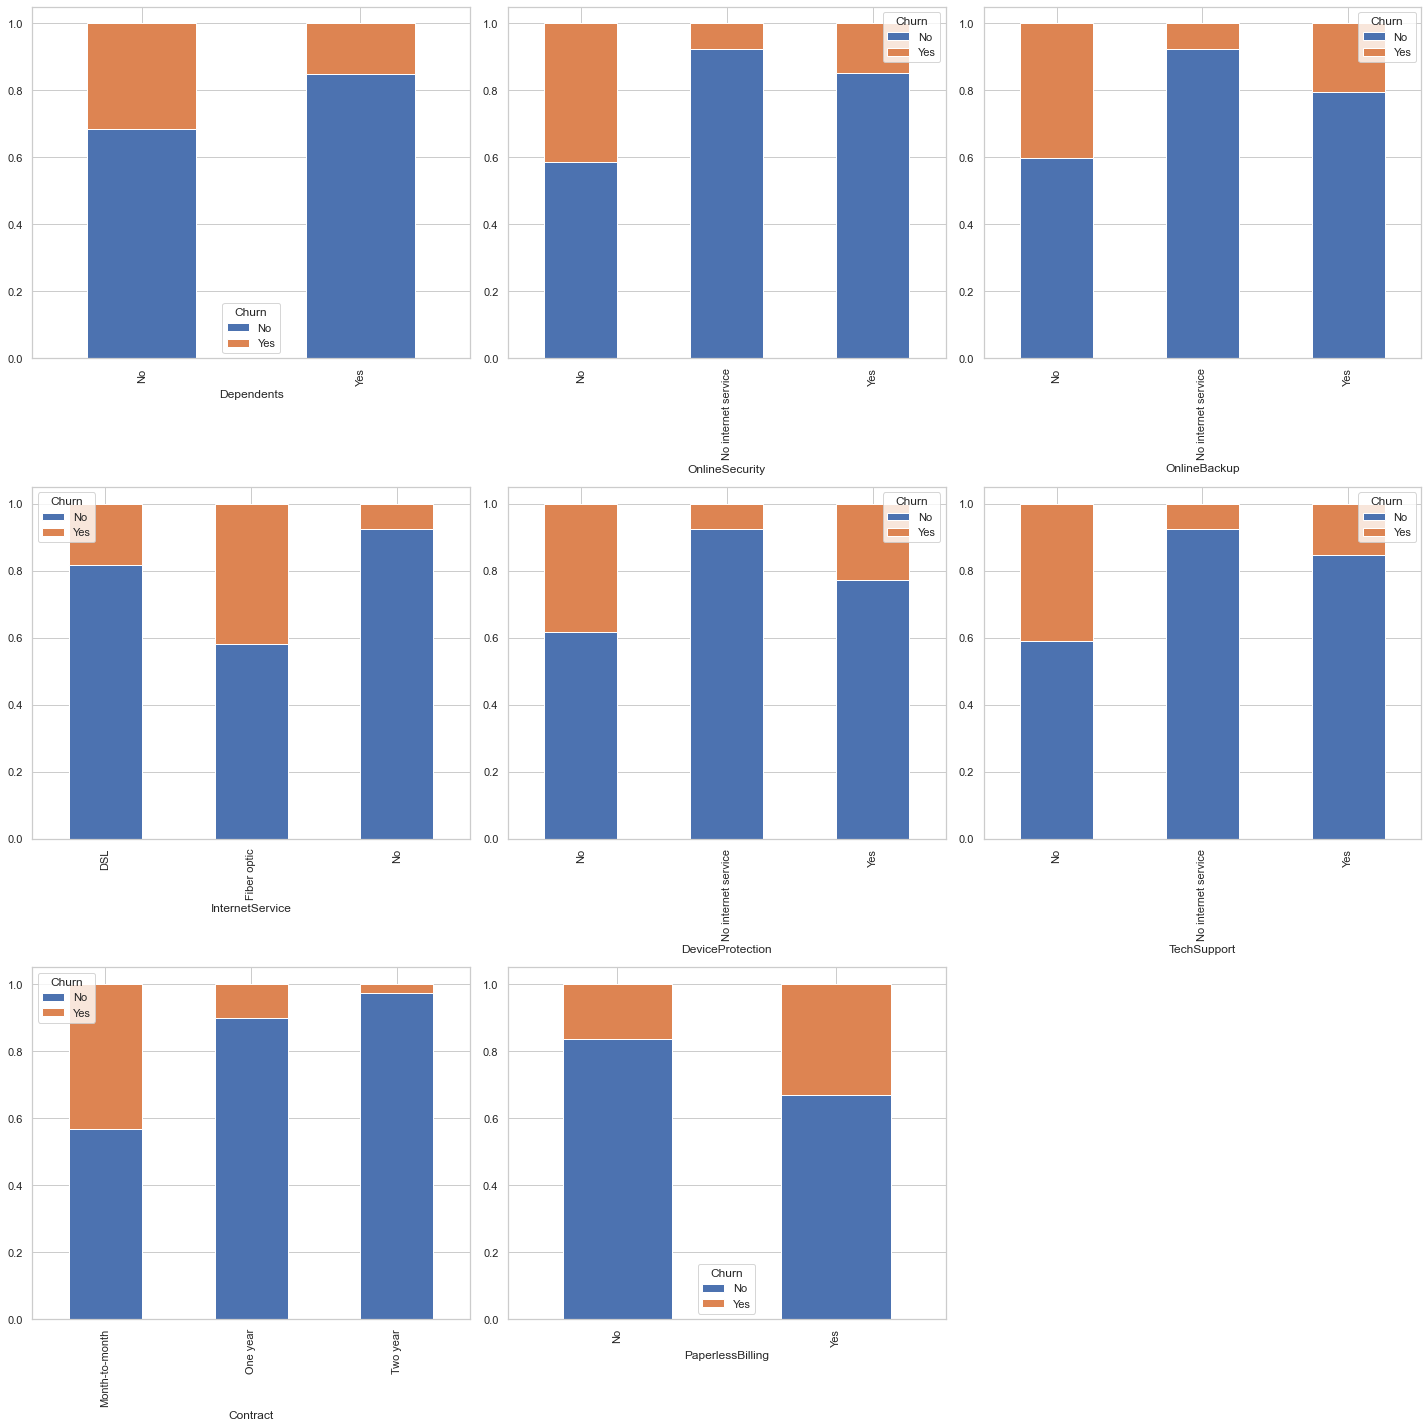

In [536]:
# C. Churn Proportion per Attribute (Plot)
# _____________________________________________________________________________________________________________________

count = 0
fig = plt.figure(figsize=(20,20))

for atribut in atribut_kategorikal:
    count +=1
    ax= plt.subplot(3,3,count)
    pd.crosstab(df[atribut],df['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Berdasarkan diagram dan tabel diatas kita dapat menyimpulkan beberapa hal :
1. Customer yang **tidak memiliki tanggungan (`No`)** lebih cenderung **'Churn'** dari pada Customer yang **memiliki tanggungan (`Yes`)**
2. Customer yang **tidak memiliki online security (`No`)** lebih cenderung **'Churn'** dari pada Customer yang lain.
3. Customer yang **tidak memiliki online backup (`No`)** lebih cenderung **'Churn'** dari pada Customer yang lain.
4. Customer yang menggunakan internet provider **Fiber Optic** lebih cenderung **'Churn'** dari pada Customer yang lain.
5. Customer yang **tidak memiliki device protection (`No`)** lebih cenderung **'Churn'** dari pada Customer yang lain.
6. Customer yang **tidak memiliki tech support (`No`)** lebih cenderung **'Churn'** dari pada Customer yang lain.
7. Customer yang jangka waktu kontraknya **Month-to-month** lebih cenderung **'Churn'** dari pada Customer yang lain.
8. Customer yang  **memiliki paperless billing** lebih cenderung **'Churn'** dari pada Customer yang lain.

## **4.C Hubungan**

#### 1. Numerikal vs Numerikal

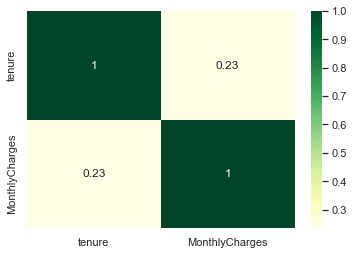

In [537]:
# A. Uji Korelasi antar Data Numerikal
# _____________________________________________________________________________________________________________________

sns.heatmap(df.corr(), cmap="YlGn",annot=True);

Berdasarkan heatmap diatas dapat disimpulkan bahwa tenure dan MonthlyCharges korelasinya positif namun lemah.

#### 2. Kategorikal vs Kategorikal

In [538]:
d_os = (df.pivot_table(index = 'Dependents', columns = 'OnlineSecurity', values = 'MonthlyCharges', aggfunc = len))
d_ob = (df.pivot_table(index = 'Dependents', columns = 'OnlineBackup', values = 'MonthlyCharges', aggfunc = len))
d_is = (df.pivot_table(index = 'Dependents', columns = 'InternetService', values = 'MonthlyCharges', aggfunc = len))
d_dp = (df.pivot_table(index = 'Dependents', columns = 'DeviceProtection', values = 'MonthlyCharges', aggfunc = len))
d_ts = (df.pivot_table(index = 'Dependents', columns = 'TechSupport', values = 'MonthlyCharges', aggfunc = len))
d_c = (df.pivot_table(index = 'Dependents', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
d_pb = (df.pivot_table(index = 'Dependents', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
d_ch = (df.pivot_table(index = 'Dependents', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

os_ob = (df.pivot_table(index = 'OnlineSecurity', columns = 'OnlineBackup', values = 'MonthlyCharges', aggfunc = len))
os_is = (df.pivot_table(index = 'OnlineSecurity', columns = 'InternetService', values = 'MonthlyCharges', aggfunc = len))
os_dp = (df.pivot_table(index = 'OnlineSecurity', columns = 'DeviceProtection', values = 'MonthlyCharges', aggfunc = len))
os_ts = (df.pivot_table(index = 'OnlineSecurity', columns = 'TechSupport', values = 'MonthlyCharges', aggfunc = len))
os_c = (df.pivot_table(index = 'OnlineSecurity', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
os_pb = (df.pivot_table(index = 'OnlineSecurity', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
os_ch = (df.pivot_table(index = 'OnlineSecurity', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

ob_is = (df.pivot_table(index = 'OnlineBackup', columns = 'InternetService', values = 'MonthlyCharges', aggfunc = len))
ob_dp = (df.pivot_table(index = 'OnlineBackup', columns = 'DeviceProtection', values = 'MonthlyCharges', aggfunc = len))
ob_ts = (df.pivot_table(index = 'OnlineBackup', columns = 'TechSupport', values = 'MonthlyCharges', aggfunc = len))
ob_c = (df.pivot_table(index = 'OnlineBackup', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
ob_pb = (df.pivot_table(index = 'OnlineBackup', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
ob_ch = (df.pivot_table(index = 'OnlineBackup', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

is_dp = (df.pivot_table(index = 'InternetService', columns = 'DeviceProtection', values = 'MonthlyCharges', aggfunc = len))
is_ts = (df.pivot_table(index = 'InternetService', columns = 'TechSupport', values = 'MonthlyCharges', aggfunc = len))
is_c = (df.pivot_table(index = 'InternetService', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
is_pb = (df.pivot_table(index = 'InternetService', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
is_ch = (df.pivot_table(index = 'InternetService', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

dp_ts = (df.pivot_table(index = 'DeviceProtection', columns = 'TechSupport', values = 'MonthlyCharges', aggfunc = len))
dp_c = (df.pivot_table(index = 'DeviceProtection', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
dp_pb = (df.pivot_table(index = 'DeviceProtection', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
dp_ch = (df.pivot_table(index = 'DeviceProtection', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

ts_c = (df.pivot_table(index = 'TechSupport', columns = 'Contract', values = 'MonthlyCharges', aggfunc = len))
ts_pb = (df.pivot_table(index = 'TechSupport', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
ts_ch = (df.pivot_table(index = 'TechSupport', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

c_pb = (df.pivot_table(index = 'Contract', columns = 'PaperlessBilling', values = 'MonthlyCharges', aggfunc = len))
c_ch = (df.pivot_table(index = 'Contract', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

pb_ch = (df.pivot_table(index = 'PaperlessBilling', columns = 'Churn', values = 'MonthlyCharges', aggfunc = len))

In [539]:
list_atribut1 = pd.DataFrame([
    'Dependents','Dependents','Dependents','Dependents','Dependents','Dependents','Dependents','Dependents',
    'OnlineSecurity', 'OnlineSecurity','OnlineSecurity','OnlineSecurity','OnlineSecurity','OnlineSecurity','OnlineSecurity',
    'OnlineBackup', 'OnlineBackup', 'OnlineBackup', 'OnlineBackup', 'OnlineBackup', 'OnlineBackup', 
    'InternetService', 'InternetService', 'InternetService', 'InternetService', 'InternetService', 
    'DeviceProtection', 'DeviceProtection', 'DeviceProtection', 'DeviceProtection', 
    'TechSupport', 'TechSupport', 'TechSupport', 
    'Contract', 'Contract', 
    'PaperlessBilling'
])

list_atribut2 = pd.DataFrame([
    'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn', 
    'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn', 
    'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn', 
    'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn', 
    'TechSupport', 'Contract', 'PaperlessBilling', 'Churn', 
    'Contract', 'PaperlessBilling', 'Churn', 
    'PaperlessBilling', 'Churn', 
    'Churn'
])

list_pivot = [
    d_os, d_ob, d_is, d_dp, d_ts, d_c, d_pb, d_ch,
    os_ob, os_is, os_dp, os_ts, os_c, os_pb, os_ch,
    ob_is, ob_dp, ob_ts, ob_c, ob_pb, ob_ch,
    is_dp, is_ts, is_c, is_pb, is_ch,
    dp_ts, dp_c, dp_pb, dp_ch,
    ts_c, ts_pb, ts_ch,
    c_pb, c_ch,
    pb_ch
]

Hypothesis
- Ho: Faktor 1 dan Faktor 2 independent (tidak terkait)
- Ha: Faktor 1 dan Faktor 2 dependent (terkait)

In [540]:
list_hubungan = []
for i in list_pivot :
    stat,p_value,dof,expected = chi2_contingency(i.fillna(1))
    if p_value > 0.05:
        list_hubungan.append('Independent')
    else:
        list_hubungan.append('Dependent')

hubungan_kategorikal= pd.DataFrame(list_hubungan)

In [541]:
list_atribut1['list_atribut2']=list_atribut2
list_atribut1['Hubungan']=list_hubungan
list_atribut1.rename(columns={0 : 'Atribut 1', 'list_atribut2' : 'Atribut 2'})

,Atribut 1,Atribut 2,Hubungan
0,Dependents,OnlineSecurity,Dependent
1,Dependents,OnlineBackup,Dependent
2,Dependents,InternetService,Dependent
3,Dependents,DeviceProtection,Dependent
4,Dependents,TechSupport,Dependent
5,Dependents,Contract,Dependent
6,Dependents,PaperlessBilling,Dependent
7,Dependents,Churn,Dependent
8,OnlineSecurity,OnlineBackup,Dependent
9,OnlineSecurity,InternetService,Dependent


#### 3. Numerikal vs Kategorikal

In [542]:
df_info

,Atribut,Tipe_Data,Jumlah_Data,Jumlah_Null,Null_%,Total_Unik,Nilai_Unik
0,Dependents,object,4930,0,0.0,2,"[Yes, No]"
1,tenure,int64,4930,0,0.0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,object,4930,0,0.0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,4930,0,0.0,3,"[No, Yes, No internet service]"
4,InternetService,object,4930,0,0.0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,4930,0,0.0,3,"[Yes, No internet service, No]"
6,TechSupport,object,4930,0,0.0,3,"[Yes, No, No internet service]"
7,Contract,object,4930,0,0.0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,4930,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,4930,0,0.0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


Diketahui :

        - Kolom kategorikal : Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, Contract, PaperlessBilling, Churn
        - Semua Data Numerik tidak terdistribrusi normal

Metode : 

        - Kruskal Wallis Test

A. Dependents

In [543]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['Dependents']=='Yes'][atribut],
        df[df['Dependents']=='No'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_dependents = pd.DataFrame(list_hasil,list_kolom)
hubungan_dependents.rename(columns={0:'Dependents'}, inplace=True)
hubungan_dependents = hubungan_dependents.T

B. Online Security

In [544]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['OnlineSecurity']=='Yes'][atribut],
        df[df['OnlineSecurity']=='No'][atribut],
        df[df['OnlineSecurity']=='No internet service'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_onlinesecurity = pd.DataFrame(list_hasil,list_kolom)
hubungan_onlinesecurity.rename(columns={0:'OnlineSecurity'}, inplace=True)
hubungan_onlinesecurity = hubungan_onlinesecurity.T

C. Online Backup

In [545]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['OnlineBackup']=='Yes'][atribut],
        df[df['OnlineBackup']=='No'][atribut],
        df[df['OnlineBackup']=='No internet service'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_onlinebackup = pd.DataFrame(list_hasil,list_kolom)
hubungan_onlinebackup.rename(columns={0:'OnlineBackup'}, inplace=True)
hubungan_onlinebackup = hubungan_onlinebackup.T

D. Internet Service

In [546]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['InternetService']=='DSL'][atribut],
        df[df['InternetService']=='Fiber Optic'][atribut],
        df[df['InternetService']=='No'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_internetservice = pd.DataFrame(list_hasil,list_kolom)
hubungan_internetservice.rename(columns={0:'InternetService'}, inplace=True)
hubungan_internetservice = hubungan_internetservice.T

E. Device Protection

In [547]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['DeviceProtection']=='Yes'][atribut],
        df[df['DeviceProtection']=='No'][atribut],
        df[df['DeviceProtection']=='No internet service'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_deviceprotection = pd.DataFrame(list_hasil,list_kolom)
hubungan_deviceprotection.rename(columns={0:'DeviceProtection'}, inplace=True)
hubungan_deviceprotection = hubungan_deviceprotection.T

F. Tech Support

In [548]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['TechSupport']=='Yes'][atribut],
        df[df['TechSupport']=='No'][atribut],
        df[df['TechSupport']=='No internet service'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_techsupport = pd.DataFrame(list_hasil,list_kolom)
hubungan_techsupport.rename(columns={0:'TechSupport'}, inplace=True)
hubungan_techsupport = hubungan_techsupport.T

G. Contract

In [549]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['Contract']=='Month-to-month'][atribut],
        df[df['Contract']=='Two year'][atribut],
        df[df['Contract']=='One year'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_contract = pd.DataFrame(list_hasil,list_kolom)
hubungan_contract.rename(columns={0:'Contract'}, inplace=True)
hubungan_contract = hubungan_contract.T

H. Paperless Billing

In [550]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['PaperlessBilling']=='Yes'][atribut],
        df[df['PaperlessBilling']=='No'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_paperlessbilling = pd.DataFrame(list_hasil,list_kolom)
hubungan_paperlessbilling.rename(columns={0:'PaperlessBilling'}, inplace=True)
hubungan_paperlessbilling = hubungan_paperlessbilling.T

I. Churn

In [551]:
list_kolom = []
list_hasil = []

for atribut in df.describe().columns:
    stat, pvalue = kruskal(
        df[df['Churn']=='Yes'][atribut],
        df[df['Churn']=='No'][atribut])
    if pvalue > 0.05:
        list_hasil.append('Tidak Berhubungan')
    else:
        list_hasil.append('Berhubungan')
    list_kolom.append(atribut)

hubungan_churn = pd.DataFrame(list_hasil,list_kolom)
hubungan_churn.rename(columns={0:'Churn'}, inplace=True)
hubungan_churn = hubungan_churn.T

In [552]:
df_numerikal_vs_kategorikal = pd.concat([hubungan_dependents, hubungan_onlinesecurity, hubungan_onlinebackup, hubungan_internetservice, hubungan_deviceprotection, hubungan_techsupport,
hubungan_contract, hubungan_paperlessbilling, hubungan_churn ], axis = 0)

df_numerikal_vs_kategorikal

,tenure,MonthlyCharges
Dependents,Berhubungan,Berhubungan
OnlineSecurity,Berhubungan,Berhubungan
OnlineBackup,Berhubungan,Berhubungan
InternetService,Berhubungan,Berhubungan
DeviceProtection,Berhubungan,Berhubungan
TechSupport,Berhubungan,Berhubungan
Contract,Berhubungan,Berhubungan
PaperlessBilling,Tidak Berhubungan,Berhubungan
Churn,Berhubungan,Berhubungan


# **5. Data Splitting**

Disini nilai 'Yes' pada kolom churn akan ditetapkan sebagai 1, dan untuk nilai 'No' pada kolom churn akan ditetapkan sebagai 0

In [553]:
df['Churn'] = np.where(df['Churn']=='Yes', 1, 0)

In [554]:
# define fetures and target
X = df.drop(['Churn'], axis = 1)
y = df['Churn']

In [555]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    stratify=y, 
    test_size=0.2,
    random_state=8
)

# **6. Data Preprocessing**

In [556]:
df_info

,Atribut,Tipe_Data,Jumlah_Data,Jumlah_Null,Null_%,Total_Unik,Nilai_Unik
0,Dependents,object,4930,0,0.0,2,"[Yes, No]"
1,tenure,int64,4930,0,0.0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,object,4930,0,0.0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,4930,0,0.0,3,"[No, Yes, No internet service]"
4,InternetService,object,4930,0,0.0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,4930,0,0.0,3,"[Yes, No internet service, No]"
6,TechSupport,object,4930,0,0.0,3,"[Yes, No, No internet service]"
7,Contract,object,4930,0,0.0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,4930,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,4930,0,0.0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


In [557]:
# A. Transformer
# _____________________________________________________________________________________________________________________
# Onehot encoding = Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, Contract, PaperlessBilling, Churn
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['Dependents', 'OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport',
    'Contract','PaperlessBilling'])
], remainder='passthrough')

Onehot encoding digunakan karena seperti yang dapat dilihat pada tabel diatas,<br>
atribut-atribut yang ingin dirubah total unik nya tidak terlalu banyak.<br>
Selain itu, setiap atribut kategorikal yang dirubah tidak memiliki urutan/ orde.

In [558]:
# B. Resampling
# _____________________________________________________________________________________________________________________
smote = SMOTE(random_state=0)
ros = RandomOverSampler(random_state=0)

Karena data kita *mild imbalance*, maka dibutuhkan penanganan untuk data imbalance tersebut.<br>
Salah satu cara untuk mengatasinya adalah menggunakan resampling.<br>
Metode resampling yang digunakan adalah metode over sampling. <br>
Karena jika menggunakan undersampling akan banyak data yang terbuang yaitu 2277 data (lebih dari 50%). <br>

In [559]:
# C. Model Benchmark
# _____________________________________________________________________________________________________________________
# 1. Logistic Regression
logreg = LogisticRegression(random_state = 0)

# 2. KNN
knn = KNeighborsClassifier()

# 3. DecsionTree
tree = DecisionTreeClassifier(random_state=0)

# 4. RandomForest
rf = RandomForestClassifier(random_state=0)

# 5. Adaboost
ada = AdaBoostClassifier(tree, random_state=0)

# 6. Gradientboost
gbc = GradientBoostingClassifier(random_state=0)

# 7. ExtremeGradientBoost
xgbc = XGBClassifier(random_state=0, verbosity=0)

Terdapat 7 metode yang akan dibandingkan hasilnya.

In [560]:
# D. Scaler
# _____________________________________________________________________________________________________________________
robust = RobustScaler()
minmax = MinMaxScaler()
standard = StandardScaler()

Terdapat 3 scaler yang akan dibandingkan.

In [561]:
# E. Polynomial
# _____________________________________________________________________________________________________________________
poly = PolynomialFeatures(degree=2)

Polynomial digunakan sebagai salah satu metode penanganan data imbalance. 

# **7. Memilih Model Benchmark**

Pemilihan model benchmark menggunakan F2 score.<br>
Karena cost dari 'False Negative' (diprediksi tidak churn, padahal aslinya churn) lebih tinggi dari pada 'False Positive' (diprediksi churn, padahal aslinya tidak churn).<br>
Sehingga dengan F2 score kita ingin lebih berfokus pada kondisi 'False Negative'

In [562]:
# Define imbalanced treatment method
models = [logreg, knn, tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

# F2 score
f2_score = make_scorer(fbeta_score, beta=2)

for i in models:
    estimator = Pipeline([
        ('transformer', transformer),
        ('scaler', robust),
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=5, 
        scoring=f2_score, 
        error_score='raise'
        )

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())


pd.DataFrame({
    'model':['logreg', 'knn', 'tree', 'rf', 'ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,logreg,0.718804,0.020333
1,knn,0.618287,0.029534
2,tree,0.529319,0.014956
3,rf,0.573667,0.019562
4,ada,0.572568,0.030013
5,gbc,0.695849,0.032215
6,xgbc,0.622641,0.031321


Berdasarkan tabel diatas, dapat dilihat bahwa nilai rata-rata recall tertinggi berada pada model Logistic Regression (logreg) yaitu 0.72.<br>
Dan jika dilihat dari nilai standar deviasinya, model logistic regression (logreg) juga cukup stabil.<br>
Namun, nilai rata-rata recall pada gbc (Gradient Boost Classifier) juga tidak terlalu berbeda jauh dengan logistic regression,<br>
hanya saja diantara semua model, nilai standar deviasi gbc (Gradient Boost Classifier) adalah yang tertinggi.<br>
Oleh karena itu, model yang akan kita tuning adalah Logistic Regression dan Gradient Boost Classifier.

# **8. Hyperparameter Tuning**

A. Logistic Regression

In [563]:
# Random Search
model_pipe_logreg = Pipeline([
    ('transformer',transformer),
    ('scaler',robust),
    ('balancing',smote),
    ('polynomial',poly),
    ('model', logreg)
])

hyper_param_random = {
    'scaler' : [robust,minmax,standard],
    'balancing' : [ros,smote],
    'polynomial__degree' : [1,2],
    'model__penalty' : ['l1','l2'],
    'model__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__C' : np.logspace(-3,3,7)
}

random_logreg = RandomizedSearchCV(
    estimator = model_pipe_logreg,
    param_distributions=hyper_param_random,
    cv=5,
    scoring=f2_score,
    n_jobs=-1,
    n_iter=200,
    random_state=0,
)

random_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'InternetService',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'Contract',
                                                                                'PaperlessBilling'])])),
                                             ('scaler', RobustScaler()),
                                             ('balancing',
                                              SMOTE(random_state=0...
                   param_distributions={'balancing': [RandomOverSampler(random_state=0),
                                                      SMOTE(random_state=0)],
                                        'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['newton-cg', 'lbfgs',
                                                          'liblinear', 'sag',
                                                          'saga'],
                                        'polynomial__degree': [1, 2],
                                        'scaler': [RobustScaler(),
                                                   MinMaxScaler(),
                                                   StandardScaler()]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [564]:
print('Logistic Regression')
print('Best_score:', random_logreg.best_score_)
print('Best_params:', random_logreg.best_params_)

Logistic Regression
Best_score: 0.7301066102494729
Best_params: {'scaler': StandardScaler(), 'polynomial__degree': 1, 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.01, 'balancing': SMOTE(random_state=0)}


B. Gradient Boost

In [565]:
# kedalaman pohon
max_depth = list(np.arange(1,30))

# learning rate
learning_rate = list(np.arange(1,100)/100)

# jumlah pohon
n_estimators = list(np.arange(50,300))

# jumlah baris train set tiap pohon (% dari total baris train set)
subsample = list(np.arange(2,10)/10)

# jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_features = list(np.arange(1,16))

# Hyperparameter space GBC
hyperparam_space_gbc = {
    'balancing':[smote,ros],
    'model__max_depth':max_depth , 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

In [566]:
# Benchmark model 1
gbc = GradientBoostingClassifier(random_state=0)

# Create the algorithm chains
estimator_gbc = Pipeline([
    ('transformer',transformer),
    ('scaler',robust),
    ('balancing',smote),
    ('polynomial',poly),
    ('model', gbc)
    ])

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, 
    param_distributions = hyperparam_space_gbc, 
    cv = 5, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=30
)

In [567]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'InternetService',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'Contract',
                                                                                'PaperlessBilling'])])),
                                             ('scaler', RobustScaler()),
                                             ('balancing',
                                              SMOTE(random_state=0...
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29],
                                        'model__max_features': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15],
                                        'model__n_estimators': [50, 51, 52, 53,
                                                                54, 55, 56, 57,
                                                                58, 59, 60, 61,
                                                                62, 63, 64, 65,
                                                                66, 67, 68, 69,
                                                                70, 71, 72, 73,
                                                                74, 75, 76, 77,
                                                                78, 79, ...],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [568]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)

GBC
Best_score: 0.7267282019317036
Best_params: {'model__subsample': 0.7, 'model__n_estimators': 63, 'model__max_features': 11, 'model__max_depth': 3, 'model__learning_rate': 0.03, 'balancing': RandomOverSampler(random_state=0)}


f2 score pada train set:
- benchmark model logistic regression: 0.7056
- hyperparameter tuning logistic regression: 0.7301
- hyperparameter tuning gradient boost: 0.7267

# **8. Performansi pada Test Set**

### Sebelum Hyperparameter Tuning

In [569]:
models={
    'Logistic Regression': LogisticRegression(random_state=0),
    'Gradient Boost': GradientBoostingClassifier(random_state=0)
}

score=[]

for i in models:

    model = Pipeline([
        ('transformer', transformer),
        ('scaler', robust),
        ('balancing', smote),
        ('model', models[i])
    ])

    # fitting
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # recall score
    score.append([fbeta_score(y_test, y_pred, beta=2)])

score_before_tuning = pd.DataFrame(score, columns=['F2 score'], index = models.keys())
score_before_tuning

,F2 score
Logistic Regression,0.712781
Gradient Boost,0.694041


### Setelah Hyperparameter Tuning

In [570]:
# Logistic Regression

# best model
logreg_tuning = random_logreg.best_estimator_

# fitting
logreg_tuning.fit(X_train, y_train)

# predict
y_pred_logreg_tuning = logreg_tuning.predict(X_test)

# recall score
f2score_logreg_tuning = fbeta_score(y_test, y_pred_logreg_tuning, beta=2)
f2score_logreg_tuning

0.7202216066481993

In [571]:
# Gradient Boost Classifier

# best model
gbc_tuning = random_gbc.best_estimator_

# fitting
gbc_tuning.fit(X_train, y_train)

# predict
y_pred_gbc_tuning = gbc_tuning.predict(X_test)

# recall score
f2score_gbc_tuning = fbeta_score(y_test, y_pred_gbc_tuning, beta=2)
f2score_gbc_tuning

0.7270847691247414

In [572]:
score_list = [f2score_logreg_tuning, f2score_gbc_tuning]

models = ['Logistic Regression','Gradient Boost']

score_after_tuning = pd.DataFrame({
    'Model': models,
    'F2 score': score_list
})

score_after_tuning

,Model,F2 score
0,Logistic Regression,0.720222
1,Gradient Boost,0.727085


## **Comparison (Test Set)**

In [573]:
# Logistic Regression

print('LogisticRegression')
print(classification_report(y_test, y_pred_logreg_tuning))

LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       713
           1       0.50      0.81      0.62       258

    accuracy                           0.74       971
   macro avg       0.71      0.76      0.71       971
weighted avg       0.80      0.74      0.75       971



In [574]:
# Gradient Boost Classifier

print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       713
           1       0.50      0.82      0.62       258

    accuracy                           0.74       971
   macro avg       0.71      0.76      0.71       971
weighted avg       0.81      0.74      0.75       971



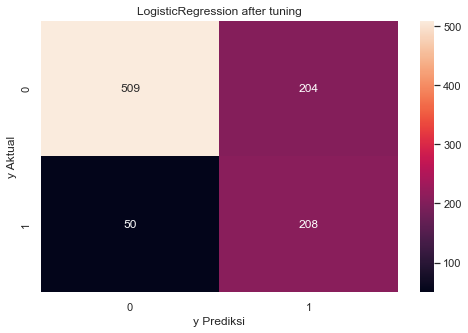

In [575]:
# LogisticRegression after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('LogisticRegression after tuning');

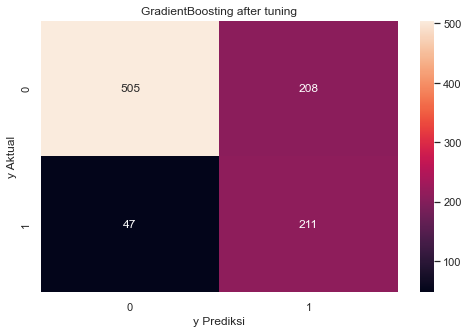

In [576]:
# Gradient Boost Classifier after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GradientBoosting after tuning');

In [599]:
score_before_tuning

,F2 score
Logistic Regression,0.712781
Gradient Boost,0.694041


In [598]:
score_after_tuning

,Model,F2 score
0,Logistic Regression,0.720222
1,Gradient Boost,0.727085


## **Summary**
---

Logistic Regression

   - Train Set:
      - Before tuning: 0.72
      - After tuning: 0.73

   - Test Set:
      - Before tuning: 0.71
      - After tuning: 0.72

---

Gradient Boost Class

   - Train Set:
      - Before tuning: 0.70
      - After tuning: 0.73

   - Test Set:
      - Before tuning: 0.69
      - After tuning: 0.73

---

Disini model yang dipilih adalah Gradient Boost Classifier.<br>
Jika kita lihat dari nilai rata-rata recall sebelum tuning baik pada train set maupun test set, Logistic Rgeression memang lebih unggul daripada Gradient Boost Classifier.<br>
Namun setelah dituning, nilai rata-rata recall Logistic Regression dan Gradient Boost Classifier pada train set sama yaitu 0.73,<br>
dan nilai rata-rata recall Gradient Boost Classifier pada test set lebih tinggi 0.01 dari Logistic Regression.<br>

Sehingga dengan demikian, untuk model yang sudah dituning, Gradient Boost Classifier sedikit lebih baik daripada Logistic Regression.<br>

Hyperparameter tuning berhasil meningkatkan F2 Score pada test set dari model dengan Gradient Boost sebesar 0.04.<br>
Performa model sebesar 0.73 bisa dikatakan belum bagus karena jumlah False Negative masih sekitar 20% dari total kelas 1 (churn). 

Metric F2 Score digunakan karena cost function dari False Negative dianggap lebih besar dari False Positif, sehingga jumlah False Negative yang dihasilkan oleh model harus diminimalkan. 


# **9. Final Model**

Final Model yang terpilih adalah Gradient Boost Classifier dengan ketentuan berikut : <br>
- subsample nya adalah 0.7
- n_estimators nya 63
- max_features nya adalah 11
- max_depth nya adalah 3
- learning rate nya adalah 0.03
- scaler yang digunakan adalah robut scaler
- metode balancing yang digunakan adalah random over sampling

In [606]:
# Gradient Boost Classifier

model_final = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('balancing',ros),
    ('model', GradientBoostingClassifier(random_state=0, subsample = 0.7, n_estimators = 63, max_features = 11, max_depth = 3, learning_rate = 0.03))
])

model_final.fit(X_train, y_train)

y_pred = model_final.predict(X_test)

# **10. Feature Importance**

In [608]:
# Nama Kolom
transformer.get_feature_names_out()

array(['onehot__Dependents_Yes',
       'onehot__OnlineSecurity_No internet service',
       'onehot__OnlineSecurity_Yes',
       'onehot__OnlineBackup_No internet service',
       'onehot__OnlineBackup_Yes', 'onehot__InternetService_Fiber optic',
       'onehot__InternetService_No',
       'onehot__DeviceProtection_No internet service',
       'onehot__DeviceProtection_Yes',
       'onehot__TechSupport_No internet service',
       'onehot__TechSupport_Yes', 'onehot__Contract_One year',
       'onehot__Contract_Two year', 'onehot__PaperlessBilling_Yes',
       'remainder__tenure', 'remainder__MonthlyCharges'], dtype=object)

In [609]:
# Nama features

features = list(transformer.get_feature_names_out())

list_features = []

for feature in features:
    list_features.append('_'.join(feature.split('_')[2:]))

list_features

['Dependents_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'tenure',
 'MonthlyCharges']

In [610]:
imp = model_final['model'].feature_importances_
imp

array([0.00051194, 0.00262769, 0.01837997, 0.01575263, 0.00503387,
       0.17470746, 0.00929727, 0.00900439, 0.        , 0.01643755,
       0.00478574, 0.13535097, 0.2348557 , 0.0138639 , 0.29726185,
       0.06212905])

In [611]:
# Feature Importance

feature_imp = pd.DataFrame({
    'Importance':imp, 
    'Feature':list_features
}).sort_values(by='Importance', ascending = False)

feature_imp

,Importance,Feature
14,0.297262,tenure
12,0.234856,Contract_Two year
5,0.174707,InternetService_Fiber optic
11,0.135351,Contract_One year
15,0.062129,MonthlyCharges
2,0.018380,OnlineSecurity_Yes
9,0.016438,TechSupport_No internet service
3,0.015753,OnlineBackup_No internet service
13,0.013864,PaperlessBilling_Yes
6,0.009297,InternetService_No


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

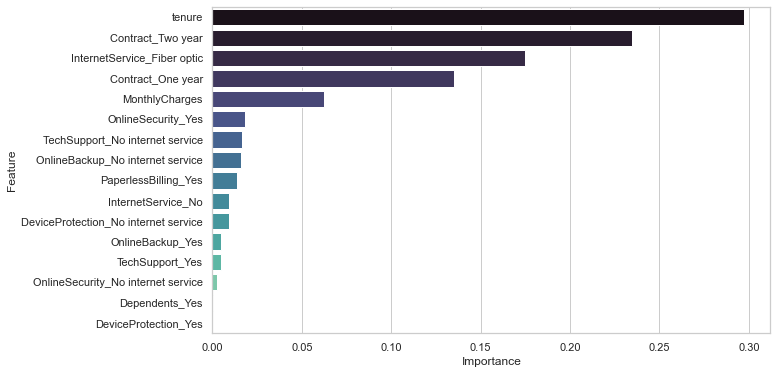

In [614]:
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")
sns.barplot(data=feature_imp, x='Importance', y='Feature', orient='h', palette='mako')

<AxesSubplot:xlabel='tenure', ylabel='Count'>

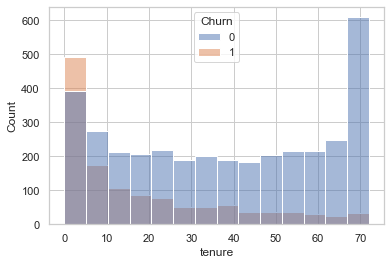

In [621]:
sns.histplot(data=df, x='tenure', hue='Churn')

<AxesSubplot:xlabel='Contract', ylabel='count'>

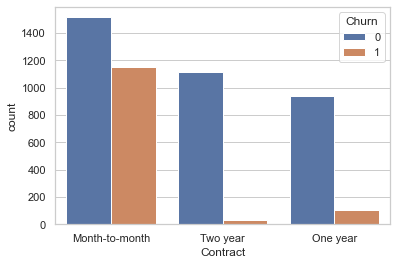

In [617]:
sns.countplot(data=df, x='Contract', hue='Churn')

<AxesSubplot:xlabel='InternetService', ylabel='count'>

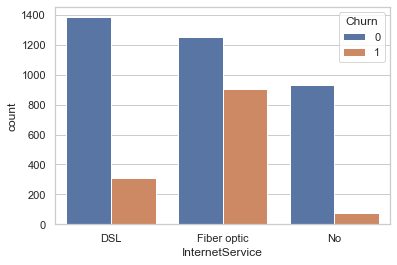

In [619]:
sns.countplot(data=df, x='InternetService', hue='Churn')

***FEATURE IMPORTANCES | GRADIENT BOOST***
<br><br>
Dari grafik diatas *feature* yang penting adalah sebagai berikut :<br>
- Tenure (jika dilihat dari EDA, semakin lama seorang customer berlangganan maka akan semakin kecil kecenderungannya untuk churn)
- Contract (jika dilihat dari EDA, semakin pendek jangka waktu kontrak customer, maka akan semakin besar kecenderungannya untuk churn)
- Internet Service (jika dilihat dari EDA, Customer yang menggunakan internet service Fiber Optic memiliki kecenderungan yang lebih besar untuk churn dibandingkan dengan customer yang menggunakan internet service yang lain.)

Sebaliknya, feature yang kurang penting adalah : <br>
- Dependents
- Device Protection



# **11. Saving Final Model**

In [623]:
# save pickle
from inspect import getblock
import pickle

# best model
gbc_tuning = random_gbc.best_estimator_

# fitting
gbc_tuning.fit(X,y)

# save dengan pickle
pickle.dump(gbc_tuning, open('best_gbc_capstone.sav','wb'))

# **12. Kesimpulan dan Rekomendasi**

In [622]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       713
           1       0.50      0.82      0.62       258

    accuracy                           0.74       971
   macro avg       0.71      0.76      0.71       971
weighted avg       0.81      0.74      0.75       971



**Kesimpulan**

Berdasarkan nilai recall pada classification report dari model terpilih, kita dapat menyimpulkan bahwa dengan menggunakan model tersebut, kita dapat mengurangi 71% customer yang tidak churn untuk tidak kita berikan special treatment sebagai bentuk untuk mempertahankan customer. Kita juga bisa mendapatkan 82% customer yang akan churn untuk lebih kita maksimalkan dalam memberikan special treatment untuk mencegah terjadinya churn. 

Dilihat dari nilai precisionnya, model kita memiliki tingkat ketepatan prediksi customer yang akan churn sebesar 50%, yang artinya kemungkinan prediksi kita benar ketika memprediksi bahwa seorang customer akan churn adalah 50%. Sehingga masih akan ada customer yang sebetulnya tidak akan churn namun diprediksi akan churn sebesar 29% (berdasarkan nilai recall) dari keseluruhan customer yang tidak churn.

**Rekomendasi**

1. Perusahaan dapat menambahkan atribut-atribut baru yang berhubungan dengan kecenderungan seorang customer churn.
2. Perusahaan dapat mencoba algoritma machine learning yang lain dan juga mencoba hyperparameter tuning kembali, coba gunakan teknik oversampling yang berbeda seperti seperti SMOTENC, dll.
3. Menganalisa lebih lanjut karakteristik data-data yang gagal diprediksi dengan benar dan mencari tahu alasannya. 